Script to generate Figure 2 in appendix D

In [1]:
from VAMP_toolbox_clean import *
from math import isnan

In [6]:
# sample sizes and dimensions

n_vec = np.array([100,100,100,100,200,500])
d_vec = np.array([1000,500,200,100,100,100])
asp_vec = np.zeros(6) # aspect ratio vector for plot labeling

In [9]:
conv_plots = [] # empty tensor to store the convergence data
damp_se = 1    # no damping needed, restart the iteration of SE if it did not converge
for i in range(len(n_vec)):
    
    rho = 0.3 # sparsity of the teacher vector
    n = n_vec[i]
    d = d_vec[i]
    asp = n/d    # aspect ratio
    asp_vec[i] = asp
    print(asp)
    delta0 = 0.01 # teacher noise
    reg = 0.1 # regularization parameter of LASSO
    my_eps = 0.3 # additional l2 penalty to enforce strict convexity (i.e. elastic net)

    # Solve the state evolution equations for the chosen problem

    niter = 100 # number of iterations for the state evolution, tuned using convergence data on SE
    
    # Iterate SE equations

    alpha1_vec,alpha2_vec,eta1_vec,eta2_vec,gamma1_vec,gamma2_vec,E1_vec,E2_vec,tau1_vec,tau2_vec = VAMP_SE_l1_unif(asp,rho,delta0,reg,niter,damp_se,my_eps,0)

    # Keeping the fixed point parameters for DR_VAMP

    V = 1/2*(1/eta1_vec[-1]+1/eta2_vec[-1])
    A1 = alpha1_vec[-1]/V
    A2 = alpha2_vec[-1]/V
    tau1 = tau1_vec[-1]
    tau2 = tau2_vec[-1]
    E = 1/2*(E1_vec[-1]+E2_vec[-1])
    
    while isnan(E) == True:   # restarting the iterations in case the fixed point was not found
        print('Restarting iteration')
        alpha1_vec,alpha2_vec,eta1_vec,eta2_vec,gamma1_vec,gamma2_vec,E1_vec,E2_vec,tau1_vec,tau2_vec = VAMP_SE_l1_unif(asp,rho,delta0,reg,niter,damp_se,my_eps,0)
        
        V = 1/2*(1/eta1_vec[-1]+1/eta2_vec[-1])
        A1 = alpha1_vec[-1]/V
        A2 = alpha2_vec[-1]/V
        tau1 = tau1_vec[-1]
        tau2 = tau2_vec[-1]
        E = 1/2*(E1_vec[-1]+E2_vec[-1])

    # Build the problem corresponding to the state evolution equations
    
    # data matrix, Gaussian here for simplicity
    
    F = np.random.normal(0,np.sqrt(1/n),(n,d)) #square i.i.d

    # teacher vector
    x0 = gauss_bernoulli(rho,d)

    # Noisy teacher output

    w = np.random.normal(0,np.sqrt(delta0),n)
    y = F@x0+w

    # Oracle_VAMP
    niter2 = 50
    damp_dr = 1  # no damping

    sol,B2_mat,B2_conv = DR_VAMP(A1,A2,V,tau2,F,niter2,damp_dr,x0,y,reg,my_eps)
    
    conv_plots.append(B2_conv)

0.1
0.2
0.5
1.0
2.0
5.0


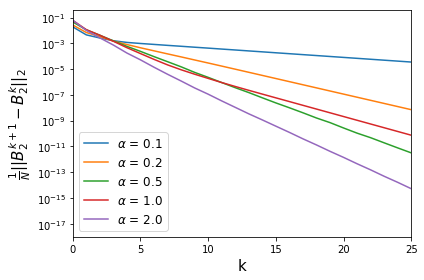

In [10]:
# Convergence plots in the log scale for y-axis, number of iterations in the x-axis

plt.figure()

for i in range(5):
    plt.plot(conv_plots[i], label = r'$\alpha$ = '+str(asp_vec[i]))

#plt.ylim(0,1)
plt.xlim(0,25)
plt.legend(fontsize = 12)
plt.xlabel('k')
plt.ylabel(r'$\frac{1}{N}||B_{2}^{k+1}-B_{2}^{k}||_{2}$')
plt.yscale('log')
plt.rc('axes', labelsize = 15)
plt.tight_layout()
plt.savefig('conv_add_l2_03', dpi=500, quality = 95)